In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, date, time
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error
from pandas.tools.plotting import scatter_matrix
%matplotlib inline
from sklearn.metrics import r2_score
from sklearn.cross_validation import cross_val_score



In [2]:
## Load the data into a DataFrame
djs = pd.read_csv('/Users/samanthafalk/GA-DSI/Projects/project-03_SFalk/Iowa_Liquor_sales_sample_10pct.csv', encoding='latin-1')
df = pd.read_csv('/Users/samanthafalk/GA-DSI/Projects/project-03_SFalk/iowa_15.csv', encoding='latin-1')

pd.options.mode.chained_assignment = None

<b>Problem Statement</b>

Given 2015 and 2016 Iowa liquor sales data, determine the best locations for a new storefront.

<b>Risks and Assumptions</b>

We chose to work with only 10% of the dataset. There were 2.7 million transactions in the entire data and we only worked with 270,000 transactions. There were also several errors in the dataset. We cleaned up the data as extensively as we could but ended up dropping a couple hundred rows that didn't have complete data. We also did not remove any outliers so there could be one stores that heavily skews the data for certain counties.

We assumed that the best place to build a new store would be near stores that are performing exceptionally well. Our main assumption here is that location is the main predictor of success for our store, but a store can perform well for several different reasons. They can have very high advertising budgets, could have monopolies on certain areas (maybe a University only allows 2 liquor stores near campus), great supply chain management, etc.


In [3]:
#Converts Date to parsible format.
djs['Date'] = [datetime.strptime(x, '%m/%d/%Y').date() for x in djs['Date']]
djs['Date'] = pd.to_datetime(djs["Date"])
djs['Year'], djs['Month'] = djs['Date'].dt.year, djs['Date'].dt.month

In [4]:
#Removes spaces from column names.
djs.columns = djs.columns.str.strip()
djs.columns = [x.replace(' ', '_') for x in djs.columns]

In [5]:
#Sam's Club
key = djs[['Store_Number', 'County', 'County_Number', 'Zip_Code', 'City']]
key.drop_duplicates(inplace=True)
key.set_index('Store_Number', inplace=True)

key = key[pd.notnull(key['County_Number'])]
KeyHelp = key.T

count_len = len(djs['County_Number'])
county_len = len(djs['County'])

for i in range(count_len):
   if np.isnan(djs['County_Number'][i]):
       try:
           djs['County_Number'][i]= KeyHelp[djs['Store_Number'][i]][1]
       except: 
           djs['County_Number'][i]

for i in range(county_len):
   try:
       if np.isnan(djs['County'][i]):
           djs['County'][i]= KeyHelp[djs['Store_Number'][i]][0]
   except: 
       djs['County'][i]


        
key.set_index('Zip_Code', inplace=True)
KeyHelp=key.T

for i in range(count_len):
   if np.isnan(djs['County_Number'][i]):
       try:
           djs['County_Number'][i]= KeyHelp[djs['Zip_Code'][i]][1]
       except: 
           djs['County_Number'][i]

for i in range(county_len):
   try:
       if np.isnan(djs['County'][i]):
           djs['County'][i]= KeyHelp[djs['Zip_Code'][i]][0]
   except: 
       djs['County'][i]



key.set_index('City', inplace=True)
KeyHelp=key.T

for i in range(count_len):
   if np.isnan(djs['County_Number'][i]):
       try:
           djs['County_Number'][i]= KeyHelp[djs['City'][i]][1]
       except: 
           djs['County_Number'][i]

for i in range(county_len):
   try:
       if np.isnan(djs['County'][i]):
           djs['County'][i]= KeyHelp[djs['City'][i]][0]
   except: 
       djs['County'][i]

In [6]:
djs.dropna(inplace=True)
djs = djs.reset_index(drop=True)

In [7]:
#DOUG'S CODE OF CONDUCT

#Converts State Bottle Cost Series to Float
djs['State_Bottle_Cost'] = (djs['State_Bottle_Cost'].replace( '[\$,)]','', regex=True )\
                            .replace( '[(]','-',   regex=True ).astype(float))

#Converts State Bottle Retail Series to Float
djs['State_Bottle_Retail'] = (djs['State_Bottle_Retail'].replace( '[\$,)]','', regex=True )\
                              .replace( '[(]','-',   regex=True ).astype(float))

#Converts Sale Dollars Series to Float
djs['Sale_(Dollars)'] = (djs['Sale_(Dollars)'].replace( '[\$,)]','', regex=True )\
                         .replace( '[(]','-',   regex=True ).astype(float))

#Converts City names to all CAPS
djs['City'] = map(lambda x: x.upper(), djs['City'])

#Calculates profit per transaction
djs['Profit'] = djs['Sale_(Dollars)'] - (djs['State_Bottle_Cost'] * djs['Bottles_Sold'])

In [8]:
#Creating dataframe with City/County name and estimated 2015 population
name_pop_df = df[['NAME', 'POPESTIMATE2015']]
name_pop_df['NAME'] = (name_pop_df['NAME'].replace( ' city','', regex=True ))

#Cleaning data.  Removing NAME with "(pt.)"
temp_df = name_pop_df.T
name_pop_df = temp_df[[ind for ind, x in enumerate(name_pop_df['NAME']) if "(pt.)" not in x]].T
name_pop_df = name_pop_df.reset_index(drop=True)

#Cleaning data.  Removing NAME with "Balance"
temp_df = name_pop_df.T
name_pop_df = temp_df[[ind for ind, x in enumerate(name_pop_df['NAME']) if "Balance" not in x]].T
name_pop_df = name_pop_df.reset_index(drop=True)

#Sorts dataframe alphabetically by NAME and remove duplicates.
name_pop_df = name_pop_df.sort(columns=['NAME'])
name_pop_df = name_pop_df.drop_duplicates(keep='first').reset_index(drop=True)

/Users/samanthafalk/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [9]:
#Add County Population
county_pop_df = name_pop_df.T
county_pop_df = county_pop_df[[ind for ind, x in enumerate(name_pop_df['NAME']) if "County" in x]].T
county_pop_df['NAME'] = (county_pop_df['NAME'].replace( ' County','', regex=True ))
county_pop_df = county_pop_df.reset_index(drop=True)
county_pop_df = county_pop_df.set_index(county_pop_df['NAME'])
del county_pop_df['NAME']
djs = djs.merge(county_pop_df, how='left', left_on="County", right_index=True)
djs.rename(columns={'POPESTIMATE2015':'County_Pop'}, inplace = True)

#Add City Population
city_pop_df = name_pop_df.T
city_pop_df = city_pop_df[[ind for ind, x in enumerate(name_pop_df['NAME']) if "County" not in x]].T
city_pop_df = city_pop_df.reset_index(drop=True)
city_pop_df['NAME'] = map(lambda x: x.upper(), city_pop_df['NAME'])
city_pop_df = city_pop_df.set_index(city_pop_df['NAME'])
del city_pop_df['NAME']
djs = djs.merge(city_pop_df, how='left', left_on="City", right_index=True)
djs.rename(columns={'POPESTIMATE2015':'City_Pop'}, inplace = True)

In [10]:
#Add Store Count per City 
store_count = djs[['Store_Number', 'City']]
store_count = store_count.sort('Store_Number').drop_duplicates()
store_count = store_count.groupby('City').count()
store_count.rename(columns={'Store_Number':'Store_Count_City'}, inplace = True)
djs = djs.merge(store_count, how='left', left_on='City', right_index=True)

#Add Store Count per County
store_count = djs[['Store_Number', 'County']]
store_count = store_count.sort('Store_Number').drop_duplicates()
store_count = store_count.groupby('County').count()
store_count.rename(columns={'Store_Number':'Store_Count_County'}, inplace = True)
djs = djs.merge(store_count, how='left', left_on='County', right_index=True)

/Users/samanthafalk/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()
/Users/samanthafalk/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [11]:
#Add Profit by City
djs_profit_by_city = djs.groupby(['City'])['Profit'].agg(([np.sum]))
djs_profit_by_city.rename(columns={'sum':'Profit_City'}, inplace = True)
djs = djs.merge(djs_profit_by_city, how='left', left_on='City', right_index=True)

#Add Profit by County
djs_profit_by_county = djs.groupby(['County'])['Profit'].agg(([np.sum]))
djs_profit_by_county.rename(columns={'sum':'Profit_County'}, inplace = True)
djs = djs.merge(djs_profit_by_county, how='left', left_on='County', right_index=True)

#Add Profit by Store
djs_profit_by_store = djs.groupby(['Store_Number'])['Profit'].agg(([np.sum]))
djs_profit_by_store.rename(columns={'sum':'Profit_Store'}, inplace = True)
djs = djs.merge(djs_profit_by_store, how='left', left_on='Store_Number', right_index=True)

In [12]:
djs.head()

,Date,Store_Number,City,Zip_Code,County_Number,County,Category,Category_Name,Vendor_Number,Item_Number,...,Year,Month,Profit,County_Pop,City_Pop,Store_Count_City,Store_Count_County,Profit_City,Profit_County,Profit_Store
0,2015-11-04,3717,SUMNER,50674,9.0,Bremer,1051100.0,APRICOT BRANDIES,55,54436,...,2015,11,27.00,24722,2009,1,9,3848.59,69164.91,3848.59
1,2016-03-02,2614,DAVENPORT,52807,82.0,Scott,1011100.0,BLENDED WHISKIES,395,27605,...,2016,3,13.76,172126,102582,43,66,569564.98,823175.13,59826.88
2,2016-02-11,2106,CEDAR FALLS,50613,7.0,Black Hawk,1011200.0,STRAIGHT BOURBON WHISKIES,65,19067,...,2016,2,151.20,133455,41255,17,73,216331.32,645252.18,58916.88
3,2016-02-03,2501,AMES,50010,85.0,Story,1071100.0,AMERICAN COCKTAILS,395,59154,...,2016,2,28.50,96021,65060,25,38,327565.86,358929.57,58282.38
4,2015-08-18,3654,BELMOND,50421,99.0,Wright,1031080.0,VODKA 80 PROOF,297,35918,...,2015,8,43.20,12773,2314,3,10,11449.65,31025.70,3962.20


In [13]:
#Creates a Dataframe with City Data.
city_df = djs[['City', 'City_Pop', 'Profit_City', 'Store_Count_City']]
city_df = city_df.set_index(city_df['City'])
del city_df['City']
city_df.drop_duplicates(inplace=True)
city_df.head()

,City_Pop,Profit_City,Store_Count_City
City,,,
SUMNER,2009,3848.59,1
DAVENPORT,102582,569564.98,43
CEDAR FALLS,41255,216331.32,17
AMES,65060,327565.86,25
BELMOND,2314,11449.65,3


In [14]:
#Creates a Dataframe with County Data.
county_df = djs[['County_Number', 'County', 'County_Pop', 'Profit_County', 'Store_Count_County']]
county_df = county_df.set_index(county_df['County'])
del county_df['County']
county_df.drop_duplicates(inplace=True)
county_df.head()

,County_Number,County_Pop,Profit_County,Store_Count_County
County,,,,
Bremer,9.0,24722,69164.91,9
Scott,82.0,172126,823175.13,66
Black Hawk,7.0,133455,645252.18,73
Story,85.0,96021,358929.57,38
Wright,99.0,12773,31025.70,10


MSE: 41580.5323722


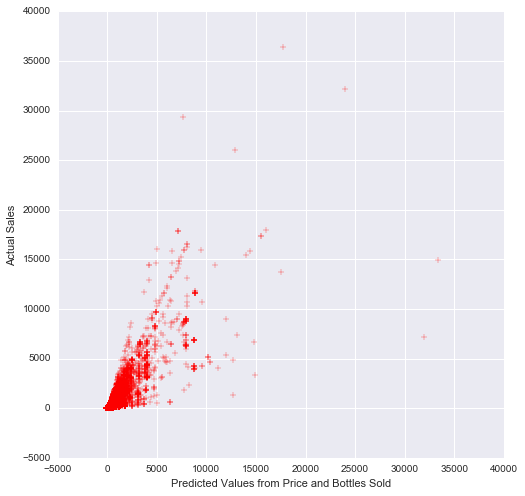

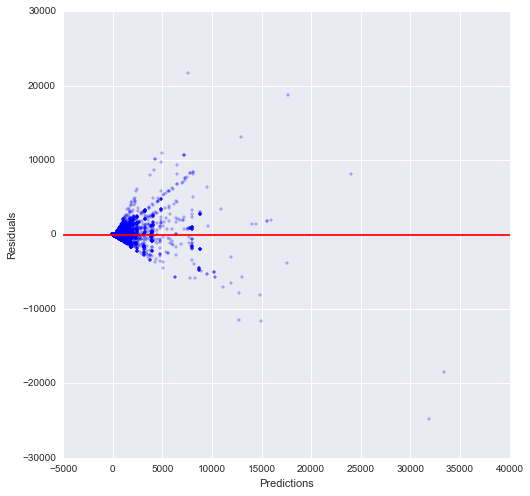

In [15]:
#Sets up regression mapping State_Bottle_Retail and Bottles_Sold to Sale_Dollars
targets = djs['Sale_(Dollars)']
djstargets = pd.DataFrame(targets)
lm = linear_model.LinearRegression()
X = djs[["State_Bottle_Retail", "Bottles_Sold"]]
y = djstargets["Sale_(Dollars)"]

model = lm.fit(X,y)
predictions = lm.predict(X)

#Creates graph of predicted values
print "MSE:", mean_squared_error(y, predictions)
plt.figure(figsize=(8,8))
plt.scatter(predictions, y, s=30, c='r', marker='+', zorder=10)
plt.xlabel("Predicted Values from Price and Bottles Sold")
plt.ylabel("Actual Sales")
plt.show()

plt.figure(figsize=(8,8))
plt.scatter(predictions, y - predictions, c = 'b', marker = '+')
plt.axhline(0, color='r');
plt.xlabel("Predictions")
plt.ylabel("Residuals");

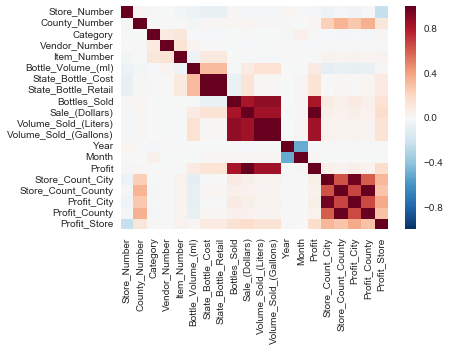

In [16]:
#Heatmap mapping correlation
sns.heatmap(djs.corr());

"plt.plot_date(djs['Date'], djs['Sale_(Dollars)'])\nplt.show()"

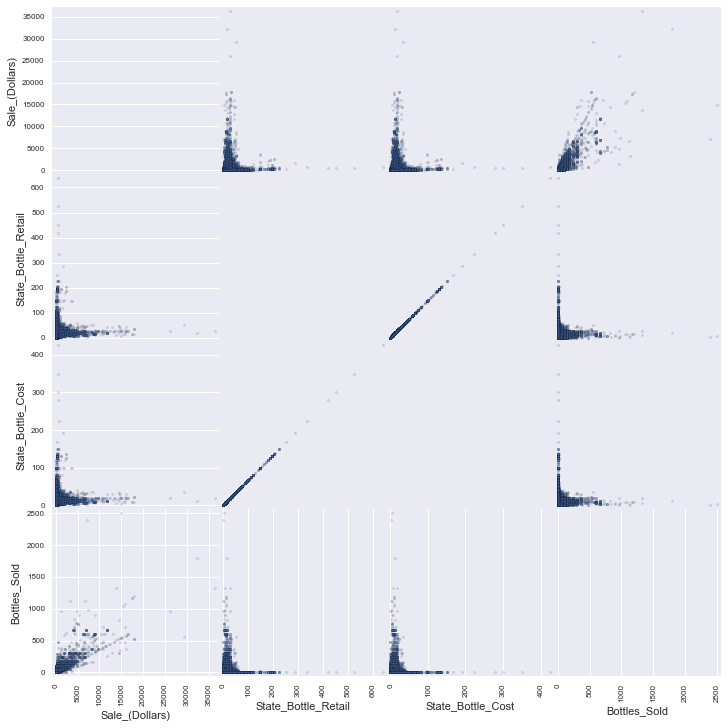

In [17]:
scatter_matrix(djs[['Date', 'Zip_Code','Sale_(Dollars)', 'State_Bottle_Retail','State_Bottle_Cost', 'Bottles_Sold']], alpha=0.2, figsize=(12, 12), diagonal='Sale_(Dollars)')


'''plt.plot_date(djs['Date'], djs['Sale_(Dollars)'])
plt.show()'''


MSE: 41580.12281


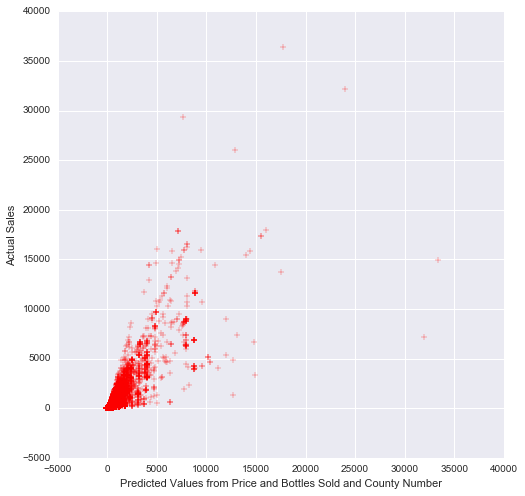

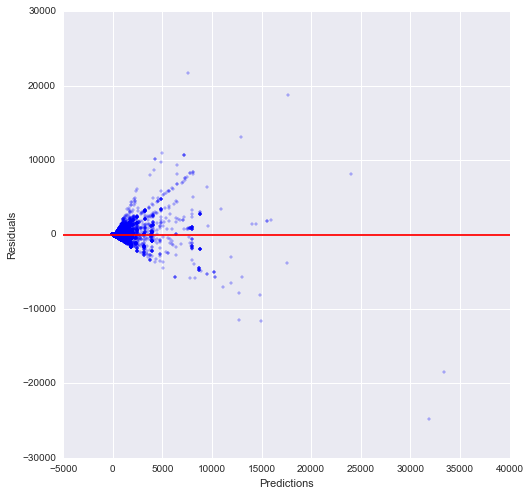

In [18]:
#Sets up regression mapping State_Bottle_Retail, Bottles_Sold, and County_Number to Sale_Dollars
targets = djs['Sale_(Dollars)']
djstargets = pd.DataFrame(targets)
lm = linear_model.LinearRegression()
X = djs[["State_Bottle_Retail", "Bottles_Sold", "County_Number"]]
y = djstargets["Sale_(Dollars)"]

model = lm.fit(X,y)
predictions = lm.predict(X)


#Creates graph of predicted values.
print "MSE:", mean_squared_error(y, predictions)
plt.figure(figsize=(8,8))
plt.scatter(predictions, y, s=30, c='r', marker='+', zorder=10)
plt.xlabel("Predicted Values from Price and Bottles Sold and County Number")
plt.ylabel("Actual Sales")
plt.show()

plt.figure(figsize=(8,8))
plt.scatter(predictions, y - predictions, c = 'b', marker = '+')
plt.axhline(0, color='r');
plt.xlabel("Predictions")
plt.ylabel("Residuals");

In [19]:
train_data=djs.loc[djs['Year'] != 2016]
test_data=djs.loc[djs['Year'] == 2016]

In [20]:
#define train data X and Y
train_X=train_data[['State_Bottle_Cost', 'Bottles_Sold', 'County_Number' ]]
train_Y=train_data[['Sale_(Dollars)']]

In [21]:
#Define test X
test_X=test_data[['State_Bottle_Cost', 'Bottles_Sold', 'County_Number']]

In [22]:
#create linear model
lr=linear_model.LinearRegression()
lr_model=lr.fit(train_X,train_Y)
predictions=lr_model.predict(train_X)

MSE: 43034.8071689


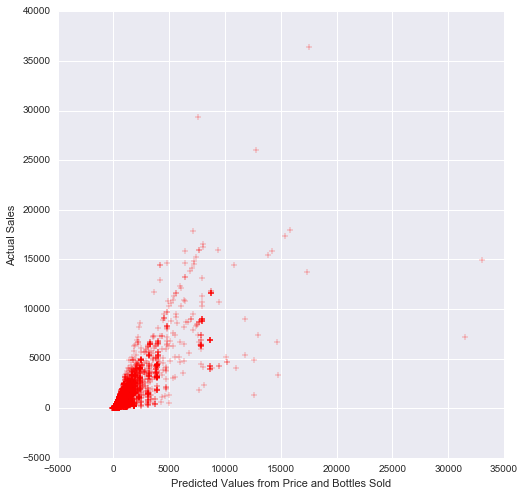

In [23]:
#plot predictions for test against y train values
print "MSE:", mean_squared_error(train_Y, predictions)
plt.figure(figsize=(8,8))
plt.scatter(predictions, train_Y, s=30, c='r', marker='+', zorder=10)
plt.xlabel("Predicted Values from Price and Bottles Sold")
plt.ylabel("Actual Sales")
plt.show()

In [24]:
#create data to plug in to model
county_values= pd.pivot_table(djs, index='County_Number', values=['State_Bottle_Cost', 'Bottles_Sold'], aggfunc=np.sum)
county_values.reset_index(inplace=True)
county_values

,County_Number,Bottles_Sold,State_Bottle_Cost
0,1.0,4650,5438.68
1,2.0,955,2377.94
2,3.0,7450,10411.70
3,4.0,8171,9903.40
4,5.0,1694,1982.02
5,6.0,6449,9140.10
6,7.0,173131,140832.42
7,8.0,17233,19480.05
8,9.0,15428,22285.26
9,10.0,12876,15406.56


In [25]:
#find predictive total sales for each county
yhat_counties=lr_model.predict(county_values)
counties_predicted=pd.DataFrame(yhat_counties)


In [26]:
#test for how many stores in each county
djs_average_profit = djs.groupby([ 'County_Number', 'Store_Number'])['Profit'].agg(([np.sum]))


In [27]:
#create dataframe with count of stores for each County
Stores_County= pd.pivot_table(djs, index='County_Number', values=['Store_Number'], aggfunc=lambda x: len(x.unique()))
Stores_County.reset_index(inplace=True)
Stores_County.columns=['County_Number', 'Num_of_Stores']
Stores_County

,County_Number,Num_of_Stores
0,1.0,8
1,2.0,1
2,3.0,6
3,4.0,6
4,5.0,3
5,6.0,6
6,7.0,73
7,8.0,15
8,9.0,9
9,10.0,10


In [28]:
#create new table with predicted county values and make sales by thousands
CountyP_Df=pd.concat([county_values['County_Number'], counties_predicted/1000], axis=1)
CountyP_Df.columns=['County_Number', 'Total_Sales_Predicted']

#add store number as a column and then divide profit by stores
CountyP_Df=pd.concat([CountyP_Df, Stores_County['Num_of_Stores']], axis=1)
CountyP_Df['PSales_per_Store']=CountyP_Df['Total_Sales_Predicted']/CountyP_Df['Num_of_Stores']
CountyP_Df.sort('PSales_per_Store', ascending=False, inplace=True)
CountyP_Df.reset_index(inplace=True, drop=True)
top10Countystore= CountyP_Df.loc[:10, :]
CountyP_Df.sort('Total_Sales_Predicted', ascending=False, inplace=True)
CountyP_Df.reset_index(inplace=True, drop=True)
top10CountyTSales= CountyP_Df.loc[:10, :]

/Users/samanthafalk/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/Users/samanthafalk/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


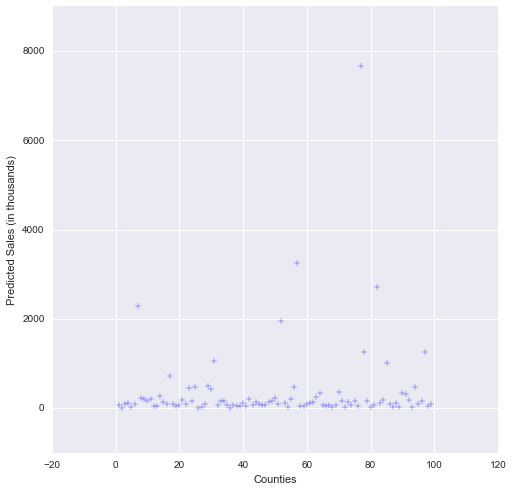

In [29]:
#plot counties and predicted total sales
plt.figure(figsize=(8,8))
plt.scatter(CountyP_Df['County_Number'], CountyP_Df['Total_Sales_Predicted'], s=30, c='blue', marker='+', zorder=10)
plt.xlabel("Counties")
plt.ylabel("Predicted Sales (in thousands)")
plt.show()

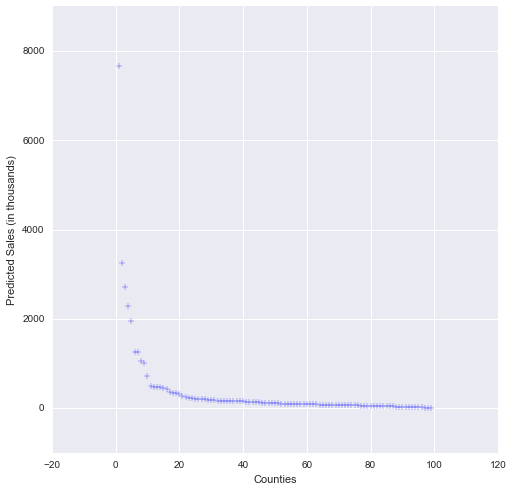

In [30]:
#plot counties and predicted total sales
plt.figure(figsize=(8,8))
plt.scatter(county_values['County_Number'], CountyP_Df['Total_Sales_Predicted'], s=30, c='blue', marker='+', zorder=10)
plt.xlabel("Counties")
plt.ylabel("Predicted Sales (in thousands)")
plt.show()

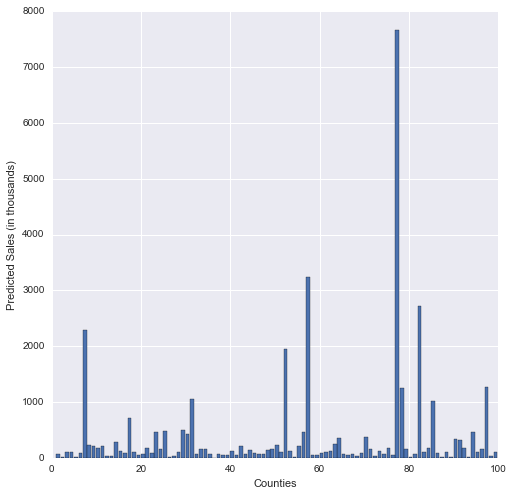

In [31]:
#plot 
plt.figure(figsize=(8,8))
plt.bar(CountyP_Df['County_Number'], CountyP_Df['Total_Sales_Predicted'])
plt.xlabel("Counties")
plt.ylabel("Predicted Sales (in thousands)")
plt.show()

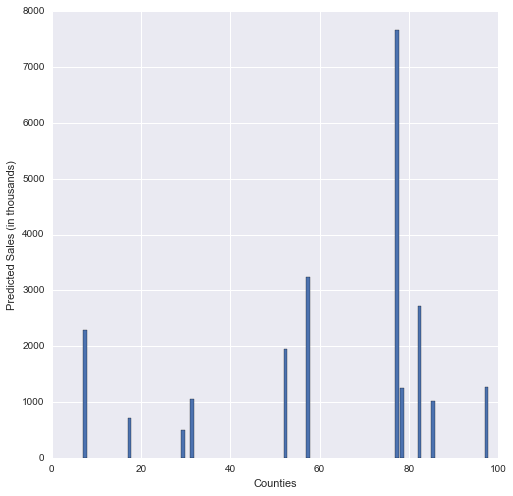

In [32]:
#plot 
plt.figure(figsize=(8,8))
plt.bar(top10CountyTSales['County_Number'], top10CountyTSales['Total_Sales_Predicted'])
plt.xlabel("Counties")
plt.ylabel("Predicted Sales (in thousands)")
plt.show()

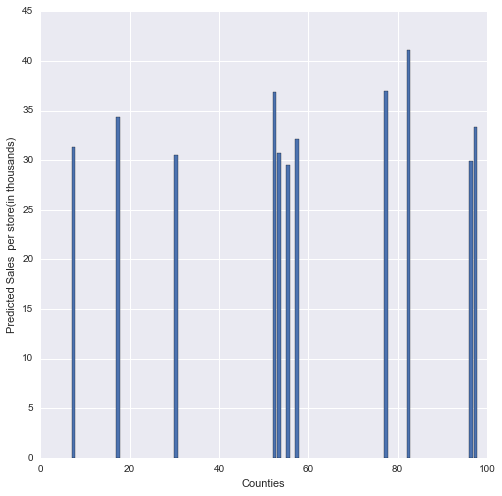

In [33]:
#plot 
plt.figure(figsize=(8,8))
plt.bar(top10Countystore['County_Number'], top10Countystore['PSales_per_Store'])
plt.xlabel("Counties")
plt.ylabel("Predicted Sales  per store(in thousands)")
plt.show()

In [34]:
lr_r2 = r2_score(train_Y, predictions)
lr_r2

0.71186213547837229

In [41]:
cross_val_score(lr_model, train_X, train_Y, n_jobs=1, cv=5, scoring='mean_squared_error').mean()

-43530.387040541616

In [38]:
#define Lasso Model
Lasso=linear_model.Lasso(alpha=1)
Lasso_model=Lasso.fit(train_X,train_Y)
predictions2=Lasso_model.predict(train_X)
predictions2

array([ 101.53890446,  132.2934349 ,  115.03473824, ...,  131.49230937,
        245.52334766,   32.94156987])

In [40]:
lr_r2 = r2_score(train_Y, predictions2)
lr_r2

0.71186197495906312

In [42]:
cross_val_score(Lasso_model, train_X, train_Y, n_jobs=1, cv=5, scoring='mean_squared_error').mean()

-43530.419839517119

In [ ]:
#Lasso does not effect the model significantly we will continue with linear models for our suggest